In [4]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm

In [5]:
# pip install pmdarima

In [6]:
# 삼성주식 찾기
df_krx = fdr.StockListing('KRX')
df_krx.head(3)

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,72000,1,1100,1.55,71100,72300,70800,15050209,1080650065800,429824343600000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,609000,1,18000,3.05,597000,610000,597000,449434,271926546000,142506000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,115400,1,5700,5.20,110300,115600,108300,7950947,897664429420,84011472921000,728002365,STK


In [7]:
ticker = df_krx[df_krx['Name']=='삼성전자']['Code']
ticker

0    005930
Name: Code, dtype: object

In [8]:
ss = fdr.DataReader(''.join(ticker.values), '2020-01-01')
# 삼성 005930 , 애플 AAPL
ss.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [9]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 850 entries, 2020-01-02 to 2023-06-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    850 non-null    int64  
 1   High    850 non-null    int64  
 2   Low     850 non-null    int64  
 3   Close   850 non-null    int64  
 4   Volume  850 non-null    int64  
 5   Change  850 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 46.5 KB


In [10]:
ss.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [11]:
len(ss)

850

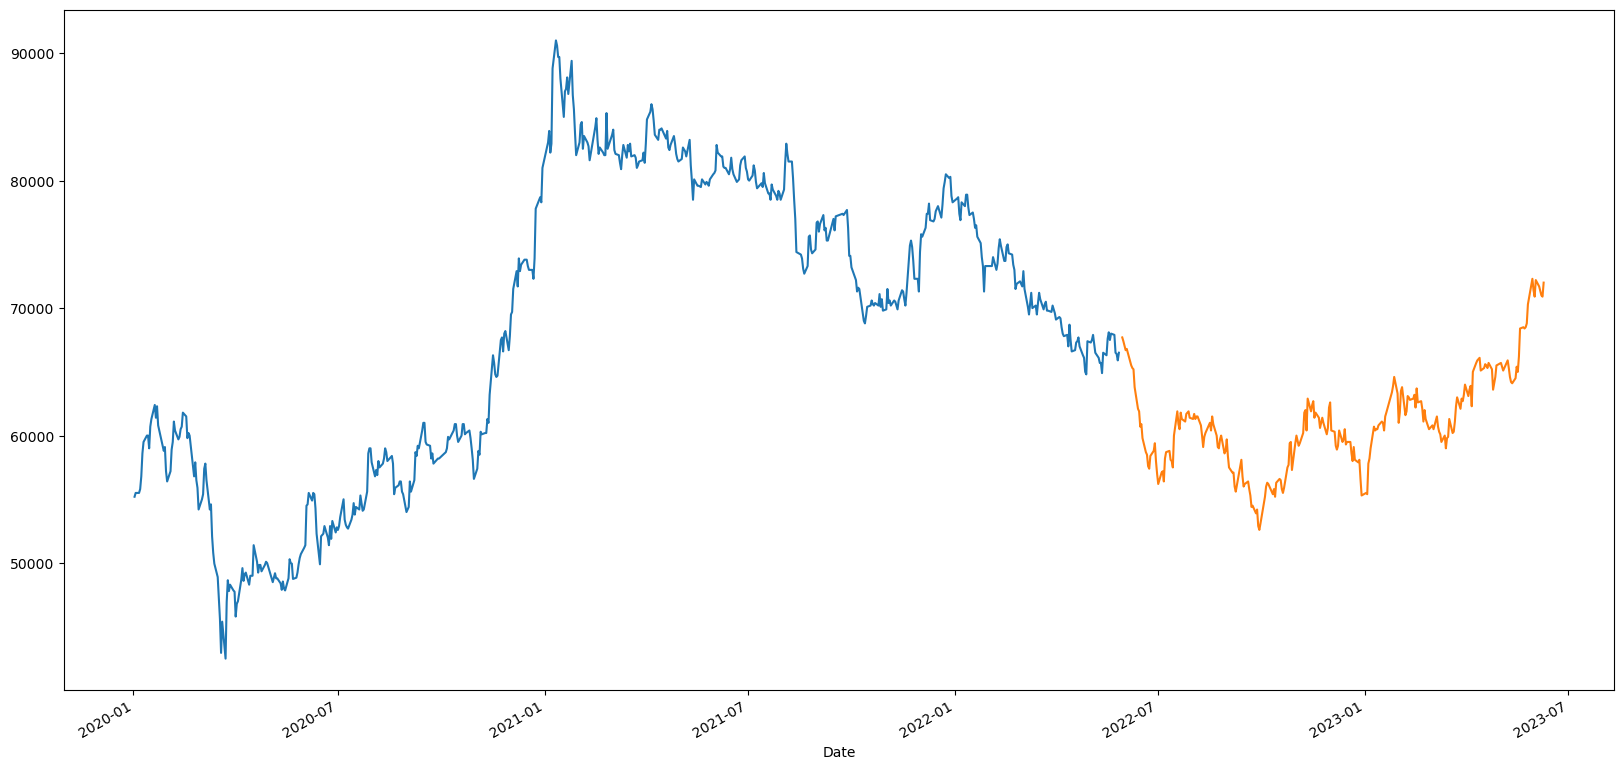

In [12]:
# train set과 test set으로 구분 (7:3)
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]
plt.subplot()
y_train.plot(figsize=(20,10))

y_test.plot(figsize=(20,10))

plt.show()


In [13]:
len(y_train)

595

In [14]:
len(y_test)

255

In [15]:
# pmdarima.arima.ndiffs를 활용한 차분 필요 여부 및 추정차수
kpss_diffs = pm.arima.ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = pm.arima.ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
print(kpss_diffs, adf_diffs)

1 1


In [16]:
# log 를 활용한 변동성 완화
ss_log = np.log(ss)

c:\Pythontemp\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Pythontemp\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [17]:
ss_log.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,10.924138,10.933107,10.915088,10.918718,16.379939,NaN
2020-01-03,10.933107,10.943764,10.913269,10.924138,16.551322,-5.214936
2020-01-06,10.913269,10.925938,10.907789,10.924138,16.145609,-inf
2020-01-07,10.927735,10.940224,10.925938,10.929529,16.119073,-5.220356
2020-01-08,10.936672,10.957800,10.931320,10.947292,16.972561,-4.021774


In [18]:
ss_log.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Change    408
dtype: int64

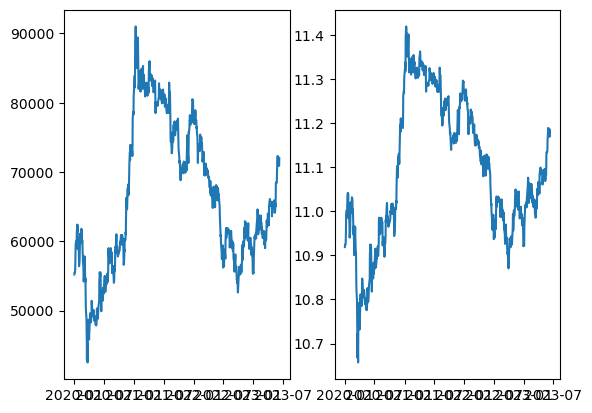

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(ss['Close'])

ax2.plot(ss_log['Close'])

plt.show()

In [20]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


정성적 그래프 분석 :


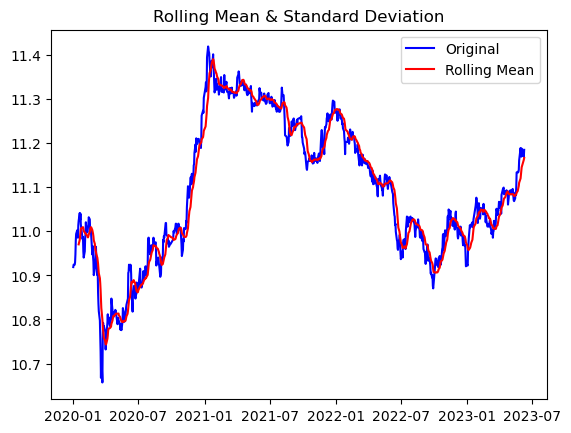

In [21]:
print()
print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')
# 정성적 그래프 분석
plot_rolling_statistics(ss_log['Close'], window=12)

In [ ]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


정성적 그래프 분석 :


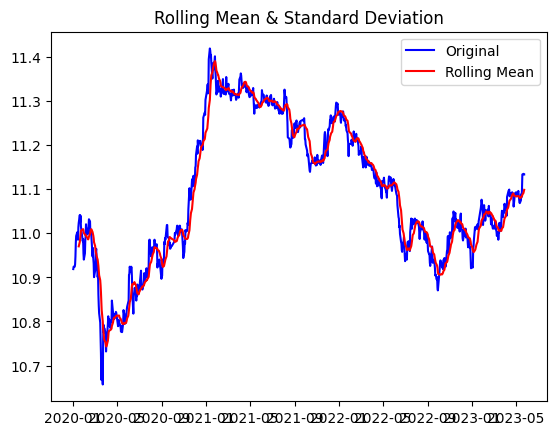


정량적 Augmented Dicky-Fuller Test :
Results of Dickey-Fuller Test:
Test Statistic                  -1.665212
p-value                          0.449120
#Lags Used                       0.000000
Number of Observations Used    839.000000
Critical Value (1%)             -3.438168
Critical Value (5%)             -2.864991
Critical Value (10%)            -2.568608
dtype: float64

시계열 분해 (Time Series Decomposition) :


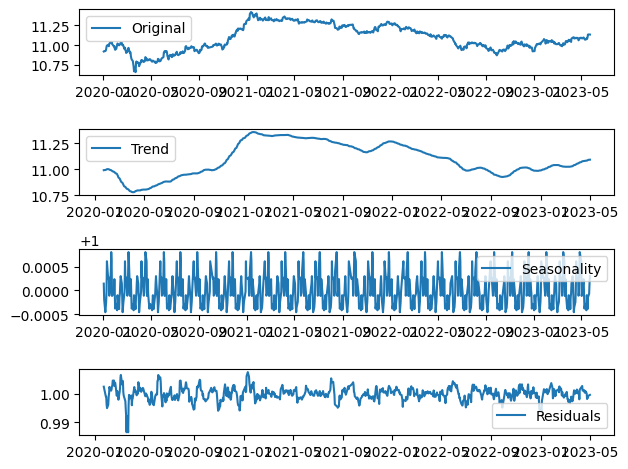

In [ ]:
print()
print('\033[31m'+'\033[1m' + "정성적 그래프 분석 :" + '\033[0m')
# 정성적 그래프 분석
plot_rolling_statistics(ss_log['Close'], window=12)

print()
print('\033[31m'+'\033[1m' + "정량적 Augmented Dicky-Fuller Test :" + '\033[0m')
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ss_log['Close'])

print()
print('\033[31m'+'\033[1m' + "시계열 분해 (Time Series Decomposition) :" + '\033[0m')
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ss_log['Close'], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ss_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

c:\Python 3.7.1\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


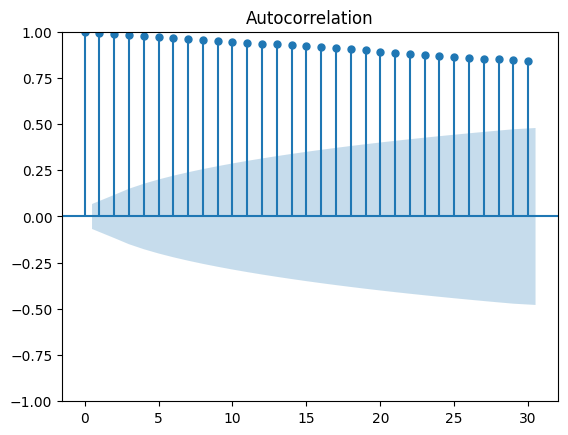

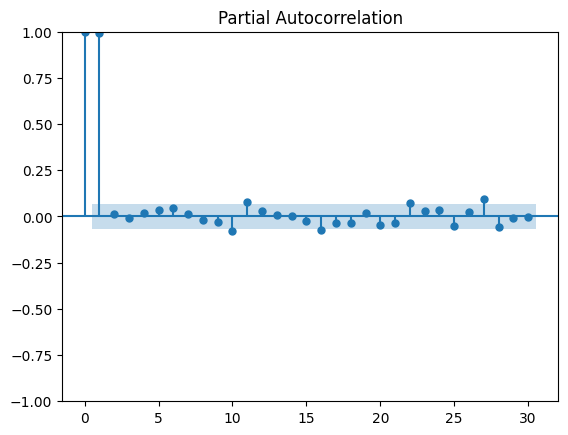

In [ ]:
# ACF, PACF 그래프 확인
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ss_log['Close'])
plot_pacf(ss_log['Close'])
plt.show()

p=2로 차분해보자

In [ ]:
# 차분을 통해서 정상성 확보
# 1차 차분
print('1차 차분')
diff_1 = ss_log['Close'].diff(periods=1).iloc[1:]
print(diff_1)
augmented_dickey_fuller_test(diff_1)

1차 차분
Date
2020-01-03    0.005420
2020-01-06    0.000000
2020-01-07    0.005391
2020-01-08    0.017762
2020-01-09    0.031198
                ...   
2023-05-18    0.018293
2023-05-19    0.032692
2023-05-22    0.001461
2023-05-23   -0.001461
2023-05-24    0.000000
Name: Close, Length: 839, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -29.187029
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    838.000000
Critical Value (1%)             -3.438177
Critical Value (5%)             -2.864995
Critical Value (10%)            -2.568610
dtype: float64


1차 차분으로도 충분하다.

In [ ]:
# 차분을 통해서 정상성 확보
# 2차 차분
print('2차 차분')
diff_2 = diff_1.diff(periods=1).iloc[1:]
print(diff_2)
augmented_dickey_fuller_test(diff_2)

2차 차분
Date
2020-01-06   -0.005420
2020-01-07    0.005391
2020-01-08    0.012372
2020-01-09    0.013436
2020-01-10   -0.015957
                ...   
2023-05-18    0.024428
2023-05-19    0.014399
2023-05-22   -0.031231
2023-05-23   -0.002922
2023-05-24    0.001461
Name: Close, Length: 838, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.172248e+01
p-value                        1.402668e-21
#Lags Used                     1.800000e+01
Number of Observations Used    8.190000e+02
Critical Value (1%)           -3.438360e+00
Critical Value (5%)           -2.865075e+00
Critical Value (10%)          -2.568653e+00
dtype: float64


### pmdarima.arima.auto_arima
pmdarima.arima.auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

In [ ]:
y_train = ss_log['Close'][:int(0.7*len(ss))]
y_test = ss_log['Close'][int(0.7*len(ss)):]

In [ ]:
model = pm.arima.auto_arima(y=y_train, d =1, start_p=0, max_p=3, start_q=0, max_q=3,
 m=1, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3120.627, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3118.628, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3118.626, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3122.363, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3117.174, Time=0.75 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.937 seconds


ARIMA(0,1,0)는 p,q,d순

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  588
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1562.182
Date:                Wed, 24 May 2023   AIC                          -3122.363
Time:                        11:03:11   BIC                          -3117.988
Sample:                             0   HQIC                         -3120.659
                                - 588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   1.02e-05     28.053      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               297.71
Prob(Q):                              0.97   Pr

- Ljung-Box (L1) (Q) : "백색잡음이다" 가 귀무가설 
그 밑에 Prob(Q)가 0.97이니 귀무가설 채택

- Jarque-Bera (JB) : "정상성을 띠고있다"가 귀무가설
그 밑에 Prob(JB)가 0.00이니 귀무가설 기각

- Heteroskedasticity (H) : "이분산성" 가 귀무가설

- Skew: 0일수록 치우쳐지지 않다.
- Kurtosis: 일반적으로 3에 가까워야 좋다(정규분포 정도) 크면 뾰족

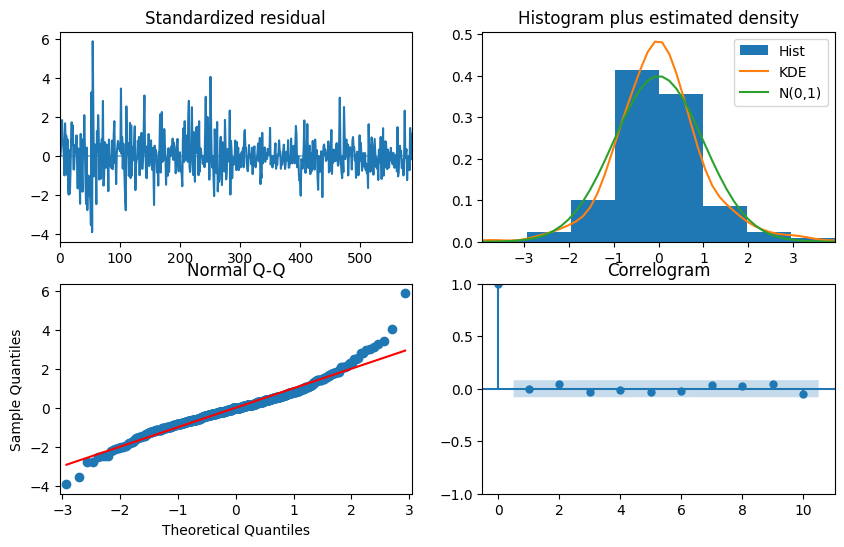

In [ ]:
## model.plot_diagnostics 이용해서 그래프로 확인 하기

model.plot_diagnostics(figsize=(10,6))
plt.show()

# 잔차가 정상성을 보인다.

In [ ]:
# 테스트 데이터를 통한 예측
y_predict = model.predict(n_periods=len(y_test))
y_predict_df = pd.DataFrame(y_predict.values, index=y_test.index,columns=['prediction'])
y_predict_df

c:\Python 3.7.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,prediction
Date,
2022-05-19,11.128732
2022-05-20,11.128732
2022-05-23,11.128732
2022-05-24,11.128732
2022-05-25,11.128732
...,...
2023-05-18,11.128732
2023-05-19,11.128732
2023-05-22,11.128732


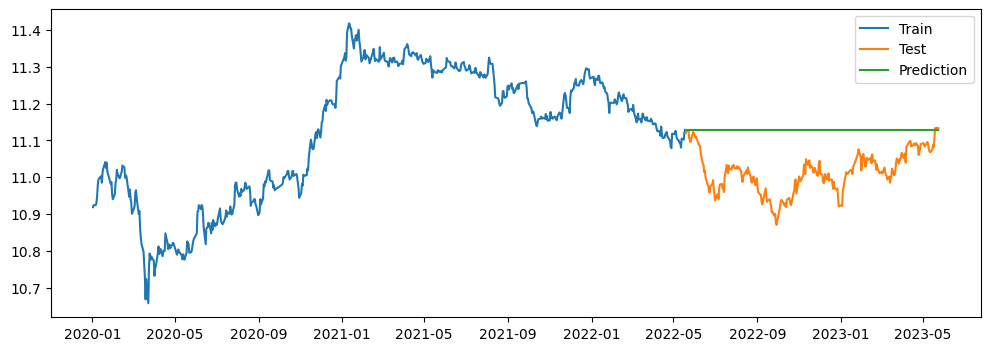

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [ ]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

In [ ]:
forcasts =[]
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## model update
    model.update(new_ob)

c:\Python 3.7.1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [ ]:
pd.DataFrame({'test':y_test, 'pred':y_pred})

,test,pred
Date,,
2022-05-19,11.119883,11.128732
2022-05-20,11.127263,11.119883
2022-05-23,11.125791,11.127263
2022-05-24,11.104957,11.125791
2022-05-25,11.103452,11.104957
...,...,...
2023-05-18,11.100436,11.082143
2023-05-19,11.133128,11.100436
2023-05-22,11.134589,11.133128


In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  840
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2259.291
Date:                Wed, 24 May 2023   AIC                          -4516.581
Time:                        13:15:18   BIC                          -4511.849
Sample:                             0   HQIC                         -4514.767
                                - 840                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   8.46e-06     31.703      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               301.65
Prob(Q):                              0.79   Pr

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()